### SHAP Exploration and Visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# machine learning
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import plot_importance, plot_tree
from math import sqrt
from sklearn.model_selection import train_test_split, KFold, cross_val_score ,RandomizedSearchCV, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import RFE, RFECV
from catboost import CatBoostRegressor
import shap

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import warnings
warnings.filterwarnings('ignore')


### Load and view data

In [88]:
OD = pd.read_excel("../Updated Variable list github/gabe/Modeling/Outputs/all_riders_vars_dataframe.xlsx").drop('Unnamed: 0', axis=1)

* Split the dataset into train, test, and val set

In [89]:
pd.reset_option('all')
# pd.set_option('display.max_rows', None)

In [90]:
OD = OD.groupby('pairs').first().reset_index()

In [91]:
OD.rename({'proportionhouses_O': 'proportion_of_households_O', 
           'proportionhouses_D': 'proportion_of_households_D'}, axis=1, inplace=True)

In [92]:
OD.head()

,pairs,passengers,ID_D,PRIMARY_NAME_FY23_D,walkshed_filename_D,WMATA_filename_D,track_miles_names_D,auto_filename_D,ID_O,PRIMARY_NAME_FY23_O,...,prox3norm_O,conn6norm_O,parks2norm_O,peds4norm_O,safenorm_O,traffic5norm_O,aesttot3norm_O,paf2norm_O,sop7norm_O,urban_dummy_O
0,MSTN_0010MSTN_002,1418,MSTN_002,Archives,ARCHIVES-NAVY MEMORIAL-PENN QUARTER,Archives-Navy Memorial,Archives,ARCHIVES-NAVY MEMORIAL-PENN QUARTER,MSTN_001,Anacostia,...,10.285137,75.577863,3.443532,31.693741,77.080763,54.616166,50.629299,0.34611,47.471791,0
1,MSTN_0010MSTN_003,156,MSTN_003,Benning Road,BENNING ROAD,Benning Road,Benning Road,BENNING ROAD,MSTN_001,Anacostia,...,10.285137,75.577863,3.443532,31.693741,77.080763,54.616166,50.629299,0.34611,47.471791,0
2,MSTN_0010MSTN_004,425,MSTN_004,Brookland-CUA,BROOKLAND-CUA,Brookland,Brookland-CUA,BROOKLAND-CUA,MSTN_001,Anacostia,...,10.285137,75.577863,3.443532,31.693741,77.080763,54.616166,50.629299,0.34611,47.471791,0
3,MSTN_0010MSTN_005,146,MSTN_005,Capitol South,CAPITOL SOUTH,Capitol South,Capitol South,CAPITOL SOUTH,MSTN_001,Anacostia,...,10.285137,75.577863,3.443532,31.693741,77.080763,54.616166,50.629299,0.34611,47.471791,0
4,MSTN_0010MSTN_006,124,MSTN_006,Cleveland Park,CLEVELAND PARK,Cleveland Park,Cleveland Park,CLEVELAND PARK,MSTN_001,Anacostia,...,10.285137,75.577863,3.443532,31.693741,77.080763,54.616166,50.629299,0.34611,47.471791,0


In [93]:
OD.shape

(8187, 148)

In [94]:
OD.drop([ 'ID_D', 'PRIMARY_NAME_FY23_D', 'walkshed_filename_D', 'WMATA_filename_D', 
           'track_miles_names_D', 'auto_filename_D', 'ID_O', 'PRIMARY_NAME_FY23_O', 'walkshed_filename_O', 
             'WMATA_filename_O', 'track_miles_names_O', 'auto_filename_O', 'O', 'D', 'Name_1_O_D',
             'MSTN_ID_D', 'STATION_ID_D', 'MSTN_D', 'MSTN_ID_O', 'STATION_ID_O', 'MSTN_O', 
              'Total Households_O', 'Total Households_D', 'COMP_MILE', 'track_miles', 'SD_FARE', 'TRAVEL_TIME', 'pub_admin_jobs_O', 
            'pub_admin_jobs_D', 'bus_tt_per_mile', 'am_parking_user', 'pm_parking_user', 'off_parking_user', 'peak_fare_per_mile2',
            'off_peak_fare_per_mile', 'google_driving_miles', 'am_new_auto_tt_per_mile2', 'pm_new_auto_tt_per_mile2', 'off_new_auto_tt_per_mile2',
             'OFF_PEAK_FARE', 'PEAK_FARE', 'HH_1_car_O', 'HH_1_car_D', 'HH_more1_car_O', 'HH_more1_car_D', 'Name_1_D_O', 'D_MSTN_ID',
             
          ], axis=1, inplace=True)   # 'Name_1_D_D', 'Name_1_O_O', 'pairs',

OD.shape

(8187, 101)

### Preprocessing

In [9]:
# X = OD.drop('passengers', axis=1)
# y = OD['passengers']

In [10]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.reset_option('all')

In [11]:
# X.isna().any().sum()

In [12]:
# y.isna().any().sum()

In [95]:
X = OD.fillna(0.000001)

### Remove highly collinear variables

* xx of these variables were dropped and due to very high multicollinearity and risk of endogeneity problem

In [14]:
# Xcorr = X.corr()
# plt.figure(figsize=(35, 30))
# sns.heatmap(Xcorr, cmap='coolwarm')

In [96]:
X1 = X.copy()

X1 = X1.drop(['All_Jobs_O', 'All_Jobs_D', 'ctpp_jobs_O', 'ctpp_jobs_D', 'urban_dummy_O', 'urban_dummy_D', 'terminal_dummy_2023_O', 
              'terminal_dummy_2023_D', 'AM_AVG_TRAINS_O',  'AM_AVG_TRAINS_D', 'PM_AVG_TRAINS_O', 'PM_AVG_TRAINS_D', 'am_new_auto_tt2', 
              'pm_new_auto_tt2', 'off_new_auto_tt2','bus_transit_minutes', 'aesttot3norm_D', 'aesttot3norm_O', 'conn6norm_D', 'conn6norm_O',
             'dens2norm_D', 'dens2norm_O', 'form3norm_D', 'form3norm_O', 'paf2norm_D', 'paf2norm_O', 'parks2norm_D', 'parks2norm_O', 
              'peds4norm_D', 'peds4norm_O', 'prox3norm_D', 'prox3norm_O', 'safenorm_D', 'safenorm_O', 'sop7norm_D', 'sop7norm_O', 
             'traffic5norm_D', 'traffic5norm_O', 'bikelane_D', 'bikelane_O', 'trip_time_mins' ], axis=1)


In [97]:
# sorted(X1.columns.to_list())
X1.shape

(8187, 60)

##### Splitting train, val, test stations with Random selection

In [98]:
X1['O_ID'] = X1['O_MSTN_ID'].str.split('_').str[1].astype('int')

In [99]:
df = X1.copy()
seed = 26
unique_stations = df['O_ID'].unique()

np.random.seed(seed)
shuffled_stations = np.random.permutation(unique_stations)

In [100]:
train_stations = shuffled_stations[:65]
val_stations = shuffled_stations[65:79]
test_stations = shuffled_stations[79:]

In [101]:
print('train_stations_shuffled: ', train_stations)
print('  ')
print('val_stations_shuffled: ', val_stations)
print('  ')
print('test_stations_shuffled: ', test_stations)

train_stations_shuffled:  [19 79 44  6 50 82 34  5 68 21 37 32 60  9 77 58 74  3 47  8 55 35 27 65
 67 73 76 12 59 26 38  4  2 10 42 14 25 64 11 23 90 40 71 75 39 28 86 15
  1 41 89 88 85 80 45 81 29 36 52 30 62 20 87 51 61]
  
val_stations_shuffled:  [83 17 70 13 72 57 48 24 43 16 31 22 53 91]
  
test_stations_shuffled:  [56 18 46 69 33 78 84 66 49  7 63 54]


In [102]:
rtrain = df[df['O_ID'].isin(train_stations)].sample(frac=1)
rX_train = rtrain.drop(['passengers', 'O_MSTN_ID', 'O_ID'], axis=1)
ry_train = rtrain['passengers']

In [103]:
rVal = df[df['O_ID'].isin(val_stations)].sample(frac=1)
rX_val = rVal.drop(['passengers', 'O_MSTN_ID', 'O_ID'], axis=1)
ry_val = rVal['passengers']

In [104]:
rTest = df[df['O_ID'].isin(test_stations)].sample(frac=1)
rX_test = rTest.drop(['passengers', 'O_MSTN_ID', 'O_ID'], axis=1)
ry_test = rTest['passengers']

In [106]:
rfecv_28 = ['bus_tt', 'sop7norm_D', 'sop7norm_O',  'bike_traveltime', 'google_driving_minutes',
           'metro_transit_minutes', 'bus_competativeness_index',
           'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D',
           'PARKING_CAPACITY_D', 'distance_to_core_D',
           'Total_Nine_to_Five_workers_D', 'Proportion_education_jobs_D',
           'bike_cap_D', 'hotelcount_D', 'restaurantcount_D', 'intercityhub_D',
           'HH_0_car_D', 'ALLPERIODS_AVG_TRAINS_O', 'proportion_of_households_O',
           'PARKING_CAPACITY_O', 'distance_to_core_O',
           'Proportion_night_weekend_jobs_O', 'Total_Nine_to_Five_workers_O',
           'Median_household_income_O', 'bike_cap_O', 'restaurantcount_O',
           'intercityhub_O', 'prop_str_dens_O', 'HH_0_car_O', 'O_MSTN_ID', 
            'passengers',]

rVal[['Name_1_D_D', 'Name_1_O_O', 'pairs']]

,Name_1_D_D,Name_1_O_O,pairs
1922,TAKOMA,L'ENFANT PLAZA,MSTN_0220MSTN_034
7457,VAN DORN STREET,FRANCONIA-SPRINGFIELD,MSTN_0830MSTN_081
6209,BENNING ROAD,PENTAGON,MSTN_0700MSTN_003
6296,WIEHLE-RESTON EAST,PENTAGON,MSTN_0700MSTN_091
5104,DUNN LORING-MERRIFIELD,LANDOVER,MSTN_0570MSTN_067
...,...,...,...
8165,VIENNA/FAIRFAX-GMU,WIEHLE-RESTON EAST,MSTN_0910MSTN_069
1145,DUNN LORING-MERRIFIELD,FARRAGUT WEST,MSTN_0130MSTN_067
7377,ANACOSTIA,FRANCONIA-SPRINGFIELD,MSTN_0830MSTN_001
2771,RONALD REAGAN WASHINGTON NATIONAL AIRPORT,SHAW-HOWARD U,MSTN_0310MSTN_073


In [28]:
# rtrain
# train_station_names = list(set(rtrain['Name_1_O_O'])) # uncomment after you've included the 'Name_1_O_O column in the df'
# val_station_names = list(set(rVal['Name_1_O_O']))   # uncomment after you've included the 'Name_1_O_O column in the df'
# test_station_names = list(set(rTest['Name_1_O_O'])) # uncomment after you've included the 'Name_1_O_O column in the df'

In [29]:
rX_train.shape, ry_train.shape, rX_val.shape, ry_val.shape, rX_test.shape, ry_test.shape,

((5847, 55), (5847,), (1260, 55), (1260,), (1080, 55), (1080,))

In [30]:
rf_reg = RandomForestRegressor(random_state=10)
rf_reg.fit(rX_train, ry_train)

RandomForestRegressor(random_state=10)

In [31]:
explainer = shap.Explainer(rf_reg, rX_train)
shap_values = explainer(rX_val, check_additivity=False) 

 99%|===================| 1248/1260 [01:09<00:00]        

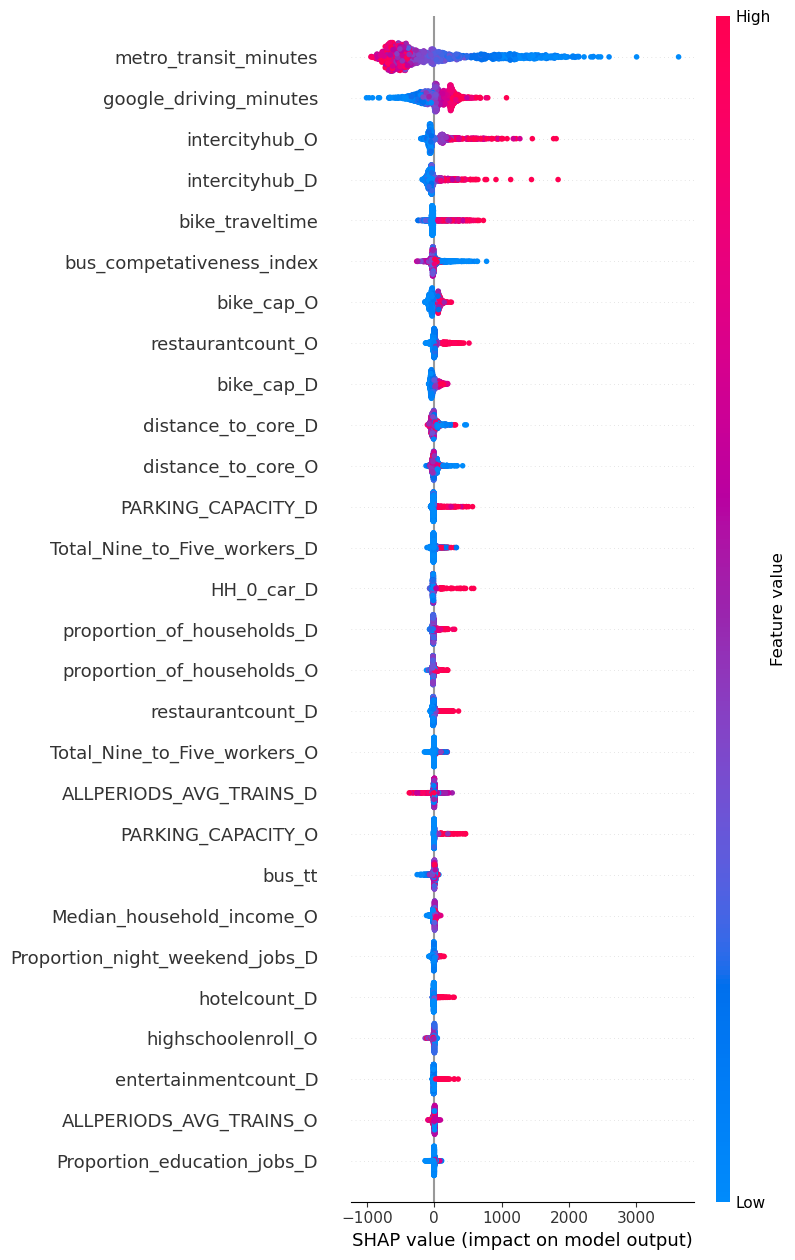

In [34]:
shap.summary_plot(shap_values, rX_val, max_display=28)

In [36]:
shap_sum = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame(list(zip(rX_train.columns, shap_sum)),
                                  columns=['feature', 'shap_importance'])
feature_importance.sort_values('shap_importance', ascending=False, inplace=True)

In [37]:
sorted_features = feature_importance['feature'].tolist()
print(sorted_features)

['metro_transit_minutes', 'google_driving_minutes', 'intercityhub_O', 'intercityhub_D', 'bike_traveltime', 'bus_competativeness_index', 'bike_cap_O', 'restaurantcount_O', 'bike_cap_D', 'distance_to_core_D', 'distance_to_core_O', 'PARKING_CAPACITY_D', 'Total_Nine_to_Five_workers_D', 'HH_0_car_D', 'proportion_of_households_D', 'proportion_of_households_O', 'restaurantcount_D', 'Total_Nine_to_Five_workers_O', 'ALLPERIODS_AVG_TRAINS_D', 'PARKING_CAPACITY_O', 'bus_tt', 'Median_household_income_O', 'Proportion_night_weekend_jobs_D', 'hotelcount_D', 'highschoolenroll_O', 'entertainmentcount_D', 'ALLPERIODS_AVG_TRAINS_O', 'Proportion_education_jobs_D', 'Median_household_income_D', 'bus_line_count_O', 'HH_0_car_O', 'prop_str_dens_D', 'highschoolenroll_D', 'college_hh_D', 'convenience_storecount_D', 'bus_line_count_D', 'college_hh_O', 'bus_stop_count_O', 'college_enroll_D', 'Proportion_night_weekend_jobs_O', 'prop_str_dens_O', 'Proportion_education_jobs_O', 'housing_units_afford_O', 'bus_stop_co

In [40]:
shap28 = sorted_features[:28]

In [41]:
rfecv28 = ['bus_tt', 'bike_traveltime', 'google_driving_minutes',
       'metro_transit_minutes', 'bus_competativeness_index',
       'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D',
       'PARKING_CAPACITY_D', 'distance_to_core_D',
       'Total_Nine_to_Five_workers_D', 'Proportion_education_jobs_D',
       'bike_cap_D', 'hotelcount_D', 'restaurantcount_D', 'intercityhub_D',
       'HH_0_car_D', 'ALLPERIODS_AVG_TRAINS_O', 'proportion_of_households_O',
       'PARKING_CAPACITY_O', 'distance_to_core_O',
       'Proportion_night_weekend_jobs_O', 'Total_Nine_to_Five_workers_O',
       'Median_household_income_O', 'bike_cap_O', 'restaurantcount_O',
       'intercityhub_O', 'prop_str_dens_O', 'HH_0_car_O']

In [44]:
set(rfecv28) - set(shap28), set(shap28) - set(rfecv28)

({'HH_0_car_O', 'Proportion_night_weekend_jobs_O', 'prop_str_dens_O'},
 {'Proportion_night_weekend_jobs_D',
  'entertainmentcount_D',
  'highschoolenroll_O'})

#### Partial dependence plots

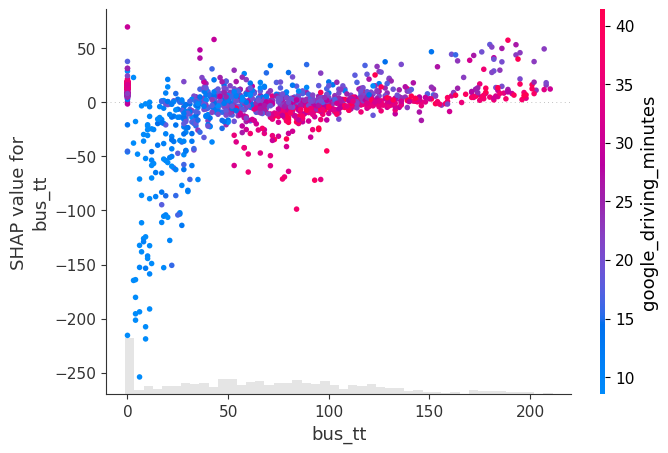

In [79]:
features = rX_train.columns

shap.plots.scatter(shap_values[:, "bus_tt"], color=shap_values)

In [74]:
rX_train.head()

,bus_tt,bike_traveltime,google_driving_minutes,metro_transit_minutes,bus_competativeness_index,ALLPERIODS_AVG_TRAINS_D,proportion_of_households_D,PARKING_CAPACITY_D,bus_line_count_D,bus_stop_count_D,...,intercityhub_O,prop_str_dens_O,Jobs_transit_O,convenience_storecount_O,highschoolenroll_O,college_enroll_O,High_School_hh_O,college_hh_O,HH_0_car_O,housing_units_afford_O
8085,108.0,0.000001,23.58,47,0.453668,5.976744,3.912976,0.000001,29,6,...,9059.000000,48.850447,4780962,0.000001,0.000001,470.000000,0.000001,0.000001,0.0,0.000001
4158,50.0,0.000001,28.38,43,0.499884,6.295455,7.083212,0.000001,31,40,...,0.000001,977.653892,68699270,0.000001,1325.000000,0.000001,176.000000,54.000000,0.0,149.000000
2264,19.0,7.783333,8.27,15,0.827358,7.574468,0.922115,0.000001,101,50,...,0.000001,1276.659048,103259214,7.000000,944.000000,0.000001,0.000001,0.000001,32.0,1738.000000
242,160.0,0.000001,26.78,40,0.336219,5.604651,4.374780,422.000000,24,45,...,23432.000000,670.688026,78475113,1.000000,752.000000,0.000001,0.000001,0.000001,15.5,258.000000
515,148.0,0.000001,27.10,43,0.424607,2.904762,5.772828,1326.000000,15,13,...,47161.000000,268.297931,46701329,1.000000,0.000001,0.000001,0.000001,0.000001,22.0,0.000001


In [65]:
shap.force_plot(explainer.expected_value, shap_values.values[0,:], rX_val.iloc[0,:])

In [70]:
shap_values.shape

(1260, 55)

In [73]:
rX_val.shape

(1260, 55)

In [80]:
rX_val.head()

,bus_tt,bike_traveltime,google_driving_minutes,metro_transit_minutes,bus_competativeness_index,ALLPERIODS_AVG_TRAINS_D,proportion_of_households_D,PARKING_CAPACITY_D,bus_line_count_D,bus_stop_count_D,...,intercityhub_O,prop_str_dens_O,Jobs_transit_O,convenience_storecount_O,highschoolenroll_O,college_enroll_O,High_School_hh_O,college_hh_O,HH_0_car_O,housing_units_afford_O
1922,66.000000,0.000001,26.00,26,0.393820,5.355556,7.393954,0.000001,28,51,...,152010.0,166.286288,25971393,1.000000,968.000000,0.000001,0.000001,0.000001,0.0,648.0
7457,22.000000,0.000001,11.75,6,0.659341,2.777778,6.516829,361.000000,13,18,...,51161.0,290.115739,15533314,0.000001,493.000000,0.000001,0.000001,0.000001,4.5,347.0
6209,79.000000,0.000001,20.95,24,0.327779,5.318182,3.304806,0.000001,30,34,...,98040.0,83.602804,3607206,0.000001,0.000001,0.000001,0.000001,0.000001,0.0,302.0
6296,151.000000,0.000001,41.27,42,0.613587,2.717391,3.411504,2300.000000,6,1,...,98040.0,83.602804,3607206,0.000001,0.000001,0.000001,0.000001,0.000001,0.0,302.0
5104,0.000001,0.000001,38.88,54,0.921187,2.904762,5.772828,1326.000000,15,13,...,11228.0,552.130730,44658342,0.000001,481.000000,0.000001,335.000000,58.000000,8.0,409.0


#### Run hyperopt

In [47]:
space = {
    'max_depth': hp.choice('max_depth', [1, 2, 5, 8, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50, None]),
    'max_features': hp.choice('max_features', [3, 4, 5, 6, 7]),
    'n_estimators': hp.choice('n_estimators', range(100, 2000, 100)),
    'min_samples_split': hp.uniform('min_samples_split', 0.01, 0.5),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.5)
}

In [48]:
def objective(params):
    regressor = RandomForestRegressor(**params)
    r2_scores = cross_val_score(regressor, rX_train, ry_train, scoring='r2', cv=5)
    neg_rmse_scores = cross_val_score(regressor, rX_train, ry_train, scoring='neg_root_mean_squared_error', cv=5)
    
    loss = -np.mean(r2_scores)  # We minimize negative R2 to maximize R2    

    rmse = -np.mean(neg_rmse_scores)  # Negate because scores are negative
    return {'loss': loss, 'status': STATUS_OK, 'rmse': rmse, 'r2': -loss}
    

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)
# Look at the detailed results including both R2 and RMSE
for trial in trials.trials:
    print(trial['result'])

100%|█████| 100/100 [53:38<00:00, 32.19s/trial, best loss: -0.42409181314352173]
{'max_depth': 9, 'max_features': 2, 'min_samples_leaf': 0.011141313852318745, 'min_samples_split': 0.03701084452008556, 'n_estimators': 811}
{'loss': 0.0004959316575279705, 'status': 'ok', 'rmse': 1260.1989660609606, 'r2': -0.0004959316575279705}
{'loss': 0.0005047384355938433, 'status': 'ok', 'rmse': 1260.2045068129598, 'r2': -0.0005047384355938433}
{'loss': 0.0004966305070113642, 'status': 'ok', 'rmse': 1260.1992390264331, 'r2': -0.0004966305070113642}
{'loss': 0.0004993448680087553, 'status': 'ok', 'rmse': 1260.2011919415338, 'r2': -0.0004993448680087553}
{'loss': 0.0005021169840415229, 'status': 'ok', 'rmse': 1260.2035716932312, 'r2': -0.0005021169840415229}
{'loss': -0.35340590171075303, 'status': 'ok', 'rmse': 1013.2884890240957, 'r2': 0.35340590171075303}
{'loss': -0.13917595748346823, 'status': 'ok', 'rmse': 1169.6156933220632, 'r2': 0.13917595748346823}
{'loss': 0.0004964527814226294, 'status': 'o

In [49]:
kfold = KFold(n_splits=5, shuffle=True, random_state=5)
krreg = RandomForestRegressor(random_state=10)

scores = cross_val_score(krreg, rX_train, ry_train, cv=kfold, scoring='r2')

print(f"R-squared: {scores.mean():.2f}")
print('scores :', scores )

R-squared: 0.65
scores : [0.61339327 0.6936771  0.66563277 0.65527999 0.64331239]
